# Multi-class classifier: MNIST images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/6.multiclass-classifier-mnist.ipynb)

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

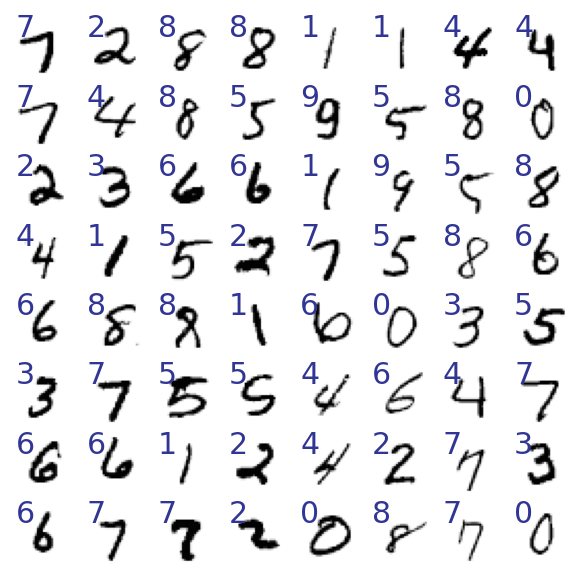

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [8]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

In [9]:
cl = RandomForestClassifier(n_estimators=900, n_jobs=-1)
cl.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=900, n_jobs=-1)

In [10]:
y_train_accuracy = cl.score(X_train, y_train)
y_accuracy = cl.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.977)

## Vanilla one hidden layer of 50 neurons, softmax on end

In [11]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [12]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [13]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3037
Epoch   100 cross entropy loss  1.4898
Epoch   200 cross entropy loss  1.4848
Epoch   300 cross entropy loss  1.4825
Epoch   400 cross entropy loss  1.4813
Epoch   500 cross entropy loss  1.4806
Epoch   600 cross entropy loss  1.4804
Epoch   700 cross entropy loss  1.4873
Epoch   800 cross entropy loss  1.4757
Epoch   900 cross entropy loss  1.4749
Epoch  1000 cross entropy loss  1.4739
LAST        cross entropy loss  1.4739


In [14]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.987


In [15]:
conf = confusion_matrix(y_train, y_pred)
print(conf)

[[747   0   0   0   0   0   0   0   0   0]
 [  0 805   1   0   0   0   1   2   0   0]
 [  2   0 804   1   3   0   4   3   5   2]
 [  0   0   0 795   0   0   0   2   2   2]
 [  2   3   2   0 776   0   0   1   0   0]
 [  2   0   6   2   2 729   5   0   2   1]
 [  2   0   0   0   1   1 750   0   0   0]
 [  0   0   0   2   3   0   0 895   1   3]
 [  0   1   2   6   0   0   1   1 832   3]
 [  4   1   1   1   4   1   0   4   4 762]]


In [16]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.961


In [17]:
confusion_matrix(y_test, y_test_pred)
print(conf)

[[747   0   0   0   0   0   0   0   0   0]
 [  0 805   1   0   0   0   1   2   0   0]
 [  2   0 804   1   3   0   4   3   5   2]
 [  0   0   0 795   0   0   0   2   2   2]
 [  2   3   2   0 776   0   0   1   0   0]
 [  2   0   6   2   2 729   5   0   2   1]
 [  2   0   0   0   1   1 750   0   0   0]
 [  0   0   0   2   3   0   0 895   1   3]
 [  0   1   2   6   0   0   1   1 832   3]
 [  4   1   1   1   4   1   0   4   4 762]]


## Track validation versus training loss

In [18]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [19]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [20]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3027   test loss  2.3026
Epoch  100 cross entropy loss  1.4930   test loss  1.5082
Epoch  200 cross entropy loss  1.4840   test loss  1.5009
Epoch  300 cross entropy loss  1.4812   test loss  1.5001
Epoch  400 cross entropy loss  1.4793   test loss  1.4981
Epoch  500 cross entropy loss  1.4782   test loss  1.4987
Epoch  600 cross entropy loss  1.4777   test loss  1.4982
Epoch  700 cross entropy loss  1.4772   test loss  1.4981
Epoch  800 cross entropy loss  1.4772   test loss  1.4979
Epoch  900 cross entropy loss  1.4772   test loss  1.4978
Epoch 1000 cross entropy loss  1.4772   test loss  1.4976
LAST        cross entropy loss  1.4772


In [21]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.984


In [22]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


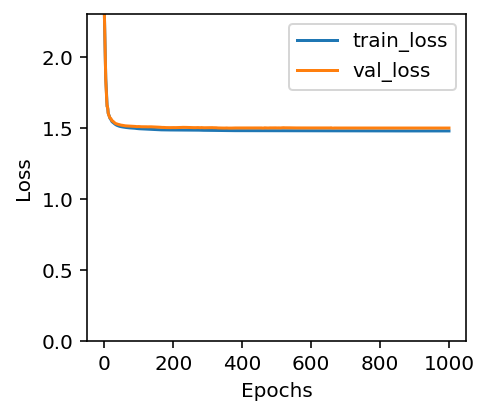

In [23]:
plot_loss(history)

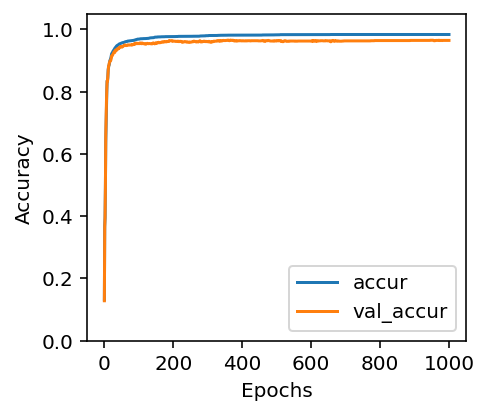

In [24]:
plot_accur(history)

## Use many neurons

In [25]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [26]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.01, nepochs=1000)

Epoch    0 cross entropy loss  2.3031   test loss  2.3029
Epoch  100 cross entropy loss  1.4787   test loss  1.4958
Epoch  200 cross entropy loss  1.4738   test loss  1.4937
Epoch  300 cross entropy loss  1.4727   test loss  1.4927
Epoch  400 cross entropy loss  1.4715   test loss  1.4909
Epoch  500 cross entropy loss  1.4710   test loss  1.4900
Epoch  600 cross entropy loss  1.4707   test loss  1.4896
Epoch  700 cross entropy loss  1.4706   test loss  1.4894
Epoch  800 cross entropy loss  1.4706   test loss  1.4894
Epoch  900 cross entropy loss  1.4702   test loss  1.4893
Epoch 1000 cross entropy loss  1.4702   test loss  1.4889
LAST        cross entropy loss  1.4702


In [27]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.991


In [28]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.971


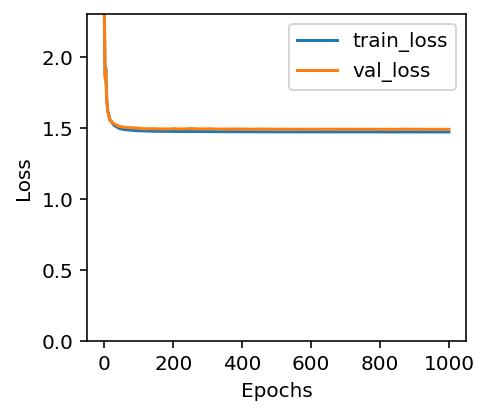

In [29]:
plot_loss(history)

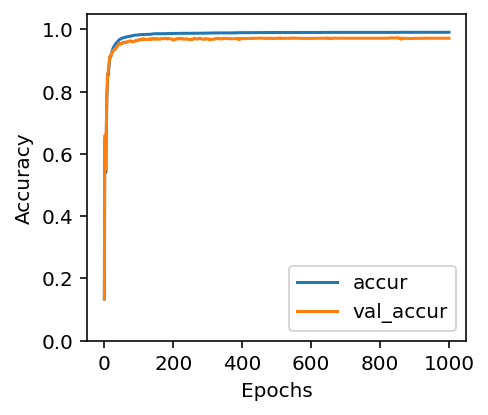

In [30]:
plot_accur(history)

## Cyclic learning rate

In [31]:
def ctrain2(model, X_train, y_train, X_test, y_test, 
            nepochs=2000,
            base_lr=0.01, max_lr=0.05):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  mode='triangular2',
                                                  step_size_up=500,
                                                  base_lr=base_lr, max_lr=max_lr,
                                                  cycle_momentum=False)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        y_pred = torch.argmax(y_pred, axis=1)
        ncorrect = torch.sum(y_pred==y_train)
        accur = ncorrect.float() / len(y_train)

        y_test_pred = model(X_test)
        loss_test = F.cross_entropy(y_test_pred, y_test)
        y_test_pred = torch.argmax(y_test_pred, axis=1)
        ncorrect = torch.sum(y_test_pred==y_test)
        loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss, loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}   LR {scheduler.get_last_lr()[0]:7.6f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
        scheduler.step()
        
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [32]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

In [33]:
history = ctrain2(model, X_train, y_train, X_test, y_test,
                  base_lr=0.005, max_lr=0.03, nepochs=1000)

Epoch    0 cross entropy loss  2.3004   test loss  2.3007   LR 0.005000
Epoch  100 cross entropy loss  1.4806   test loss  1.5015   LR 0.010000
Epoch  200 cross entropy loss  1.4731   test loss  1.4940   LR 0.015000
Epoch  300 cross entropy loss  1.4715   test loss  1.4919   LR 0.020000
Epoch  400 cross entropy loss  1.4706   test loss  1.4905   LR 0.025000
Epoch  500 cross entropy loss  1.4702   test loss  1.4912   LR 0.030000
Epoch  600 cross entropy loss  1.4702   test loss  1.4912   LR 0.025000
Epoch  700 cross entropy loss  1.4699   test loss  1.4907   LR 0.020000
Epoch  800 cross entropy loss  1.4699   test loss  1.4908   LR 0.015000
Epoch  900 cross entropy loss  1.4695   test loss  1.4889   LR 0.010000
Epoch 1000 cross entropy loss  1.4691   test loss  1.4890   LR 0.005000
LAST        cross entropy loss  1.4691


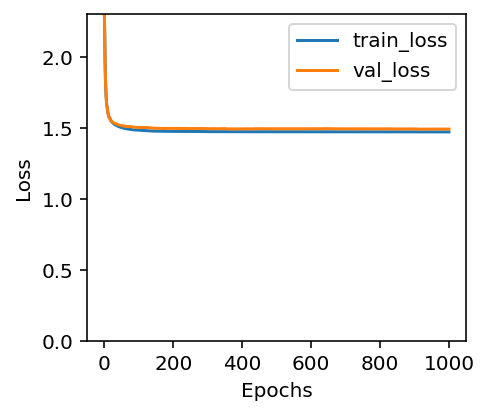

In [34]:
plot_loss(history)

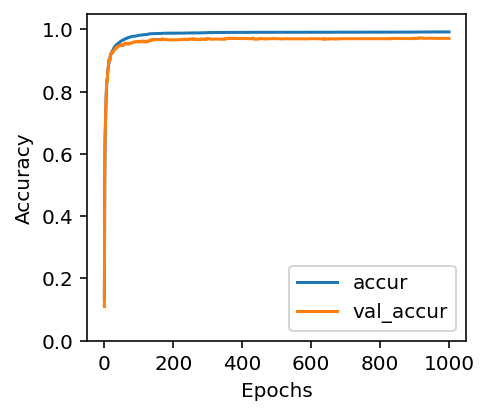

In [35]:
plot_accur(history)